In [1]:
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pandas as pd
from numpy import quantile
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from data_loader import load_data

In [2]:
from_date = datetime.datetime(2010, 6, 29) # TSLA IPO date
to_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=' + from_date.strftime('%s') + '&period2=' + to_date.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/tsla_HistoricalData.csv'
max_age_days = 7

df = load_data(csv_url, local_file, max_age_days)

Using local file


In [3]:
""" Data Transformation """
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [4]:
""" Chart Variables"""
start_year = 2010

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df['Adj Close'].last_valid_index()

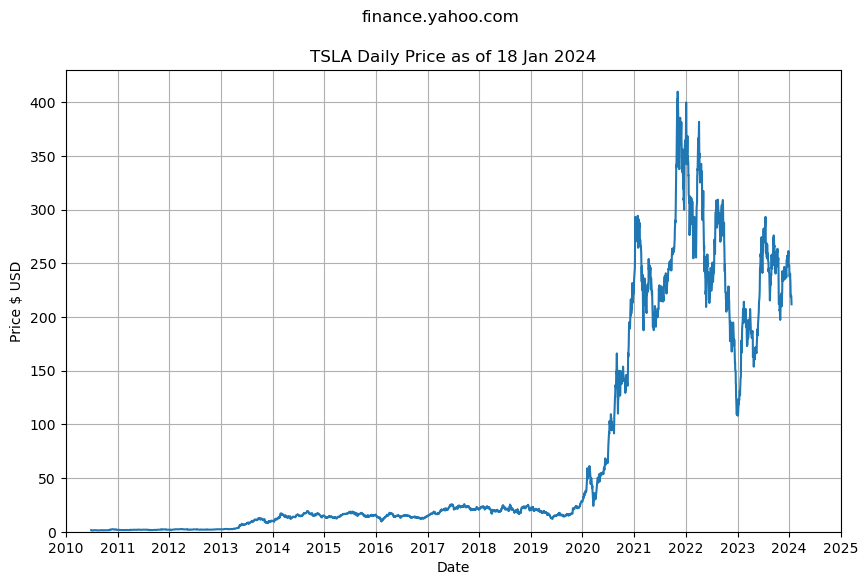

In [5]:
plt.figure(figsize=(10, 6))
colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Adj Close'], color=colors[0]['color'])
plt.xlabel('Date')
plt.ylabel('Price $ USD')
plt.suptitle('finance.yahoo.com')
plt.title('TSLA Daily Price as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
plt.ylim(bottom=0) #, top=top_limit)     
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.grid(True)

plt.savefig(os.path.join('..', 'pages', 'images', 'tsla-history.png'), bbox_inches='tight')
plt.show()

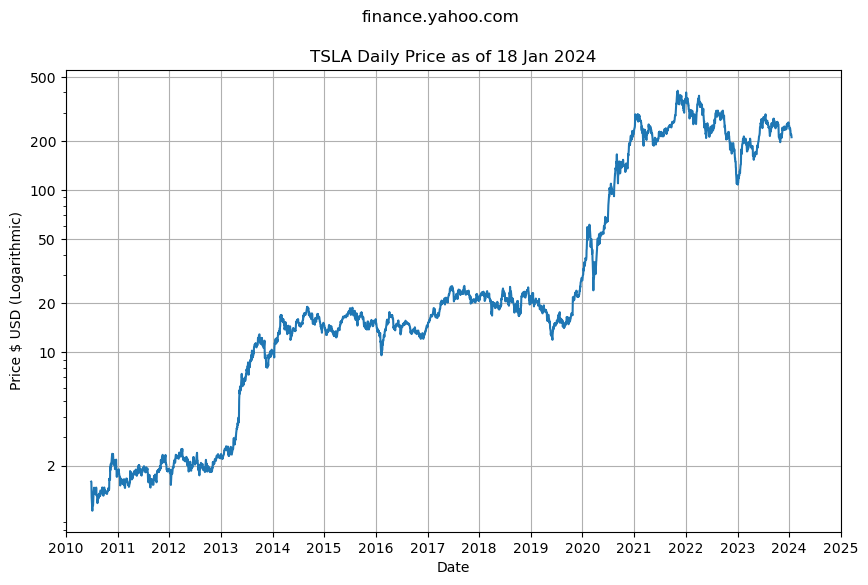

In [6]:
# Define the y-tick values and labels
yticks = [2, 10, 20, 50, 100, 200, 500]
yticksformatted = [f'{ytick:.0f}' for ytick in yticks]
yticklabels = [str(ytick) for ytick in yticks]

plt.figure(figsize=(10, 6))
colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Adj Close'], color=colors[0]['color'])
plt.xlabel('Date')
plt.ylabel('Price $ USD (Logarithmic)')
plt.suptitle('finance.yahoo.com')
plt.title('TSLA Daily Price as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
plt.yscale('log')
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
plt.yticks(yticks, yticklabels)
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.grid(True)

plt.savefig(os.path.join('..', 'pages', 'images', 'tsla-history-log.png'), bbox_inches='tight')
plt.show()



In [7]:
""" Year over Year (YoY) change based on 252 trading days per year """
annual_trading_days = 252
df['YoY'] = df['Adj Close'].pct_change(periods=annual_trading_days)*100

quantile_lower = 0.25
quantile_median = 0.5
quantile_upper = 0.75
multi_year = 5
multi_year_extended = 2

# Calculate the lower and upper percentile over the previous 1 year
df['YoY_lower'] = df['YoY'].rolling(window=annual_trading_days).quantile(quantile_lower)
df['YoY_median'] = df['YoY'].rolling(window=annual_trading_days).quantile(quantile_median)
df['YoY_upper'] = df['YoY'].rolling(window=annual_trading_days).quantile(quantile_upper)

# Add multi-year 
df['MY_lower'] = df['YoY'].rolling(window=(annual_trading_days*multi_year)).quantile(quantile_lower)
df['MY_median'] = df['YoY'].rolling(window=(annual_trading_days*multi_year)).quantile(quantile_median)
df['MY_upper'] = df['YoY'].rolling(window=(annual_trading_days*multi_year)).quantile(quantile_upper)

# Add multi-year 
df['MYX_lower'] = df['YoY'].rolling(window=(annual_trading_days*multi_year*multi_year_extended)).quantile(quantile_lower)
df['MYX_median'] = df['YoY'].rolling(window=(annual_trading_days*multi_year*multi_year_extended)).quantile(quantile_median)
df['MYX_upper'] = df['YoY'].rolling(window=(annual_trading_days*multi_year*multi_year_extended)).quantile(quantile_upper)

print('Over the last ' + str(multi_year) + ' years')
print('25th percentile YoY change is ' + str(df['MY_lower'].iloc[-1].round(2)) + '%')
print('50th percentile YoY change is ' + str(df['MY_median'].iloc[-1].round(2)) + '%')
print('75th percentile YoY change is ' + str(df['MY_upper'].iloc[-1].round(2)) + '%')
print('\nOver the last ' + str(multi_year*multi_year_extended) + ' years')
print('25th percentile YoY change is ' + str(df['MYX_lower'].iloc[-1].round(2)) + '%')
print('50th percentile YoY change is ' + str(df['MYX_median'].iloc[-1].round(2)) + '%')
print('75th percentile YoY change is ' + str(df['MYX_upper'].iloc[-1].round(2)) + '%')

Over the last 5 years
25th percentile YoY change is -13.25%
50th percentile YoY change is 24.41%
75th percentile YoY change is 173.34%

Over the last 10 years
25th percentile YoY change is -9.46%
50th percentile YoY change is 19.03%
75th percentile YoY change is 78.69%


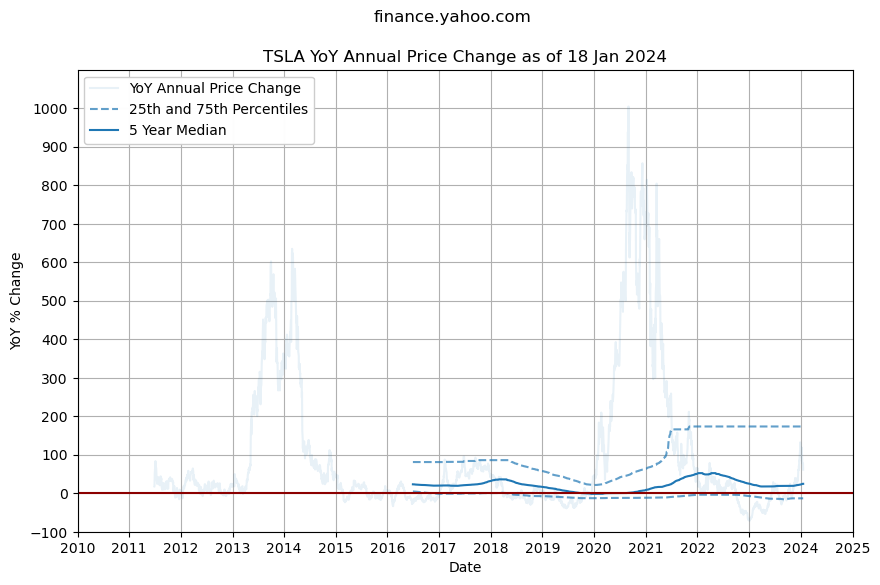

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['YoY'], label='YoY Annual Price Change', color=colors[0]['color'], alpha=0.1)
quantile_label = str(int(quantile_lower*100)) + 'th and ' + str(int(quantile_upper*100)) + 'th Percentiles'
plt.plot(df.index, df['MY_lower'], color=colors[0]['color'], linestyle='--', alpha=0.7, label=quantile_label)
plt.plot(df.index, df['MY_median'], color=colors[0]['color'], label=str(multi_year) + ' Year Median')
plt.plot(df.index, df['MY_upper'], color=colors[0]['color'], linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.suptitle('finance.yahoo.com')
plt.title('TSLA YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
top_limit = 1100
bottom_limit = -100
plt.ylim(bottom=bottom_limit, top=top_limit)
plt.yticks(range(bottom_limit, top_limit, 100))
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.axhline(y=0, color='darkred')  # Add horizontal line at y=0
plt.grid(True)

legend = plt.legend(loc='upper left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)

plt.savefig(os.path.join('..', 'pages', 'images', 'tsla-yoy.png'), bbox_inches='tight')
plt.show()

In [9]:
if '2018-01-02' in df.index:
    print(df.loc['2018-01-02'])
else:
    print('Date not found in index')
if '2020-01-02' in df.index:
    print(df.loc['2020-01-02'])
else:
    print('Date not found in index')    

Open          2.080000e+01
High          2.147400e+01
Low           2.073333e+01
Close         2.136867e+01
Adj Close     2.136867e+01
Volume        6.528300e+07
YoY           4.999767e+01
YoY_lower     3.325497e+01
YoY_median    5.581441e+01
YoY_upper     6.788330e+01
MY_lower      5.608857e-01
MY_median     3.181632e+01
MY_upper      8.592935e+01
MYX_lower              NaN
MYX_median             NaN
MYX_upper              NaN
Name: 2018-01-02 00:00:00, dtype: float64
Open          2.830000e+01
High          2.871333e+01
Low           2.811400e+01
Close         2.868400e+01
Adj Close     2.868400e+01
Volume        1.429815e+08
YoY           3.873984e+01
YoY_lower    -2.401100e+01
YoY_median   -1.357712e+01
YoY_upper    -4.524843e+00
MY_lower     -1.288184e+01
MY_median    -1.582469e+00
MY_upper      2.130326e+01
MYX_lower              NaN
MYX_median             NaN
MYX_upper              NaN
Name: 2020-01-02 00:00:00, dtype: float64


In [10]:
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
dfTargets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfTargets = dfTargets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfTargets.columns = dfTargets.columns.str.strip()
# Remove leading/trailing white spaces from data
dfTargets = dfTargets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
#dfTargets = dfTargets.applymap(lambda x: x.strip() if isinstance(x, str) else str(x).strip())
dfTargets['Date'] = pd.to_datetime(dfTargets['TargetDate'],dayfirst=True)
dfTargets['ForecastDate'] = pd.to_datetime(dfTargets['ForecastDate'],dayfirst=True)
dfTargets.set_index('Date', inplace=True)
dfTargets = dfTargets.sort_index()
for col in dfTargets.columns:
    print(f'{col}: {dfTargets[col].dtype}')


Year: int64
Source: object
Bear: float64
Base: float64
Bull: float64
ForecastDate: datetime64[ns]
TargetDate: object
Note: object
Link: object


In [11]:
def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

# 5-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2022-08-25', 3), axis=1)


In [12]:
colors = {}
colors['tsla']='#3f77e4'
colors['ark']={
    'bear': 'darkorange',
    'base': '#888888',
    'bull': 'orange',
}
colors['other']=[
    'mediumseagreen',#'#3CB371',
    'olivedrab',#'#6B8E23',
    'green',#'#008000',
    'darkgreen',#'#006400',
    'mediumseagreen',#'#3CB371',
    'darkseagreen',#'#8FBC8F',
    'limegreen',#'#32CD32',
    'seagreen',#'#2E8B57',
    'forestgreen',#'#228B22',
    'yellowgreen',#'#9ACD32',
    'darkolivegreen',#'#556B2F',
    'olive',#'#808000',

    'springgreen',#'#00FF7F',
    'mediumspringgreen',#'#00FA9A',

    # light green colors
    'lightgreen',#'#90EE90',
    'palegreen',#'#98FB98',

    # bright green colors
    'greenyellow',#'#ADFF2F',
    'lawngreen',#'#7CFC00',
    'lime',#'#00FF00',
]



InvestA uses mediumseagreen
RandyKirk uses olivedrab
SMR uses green


KeyError: 'Price'

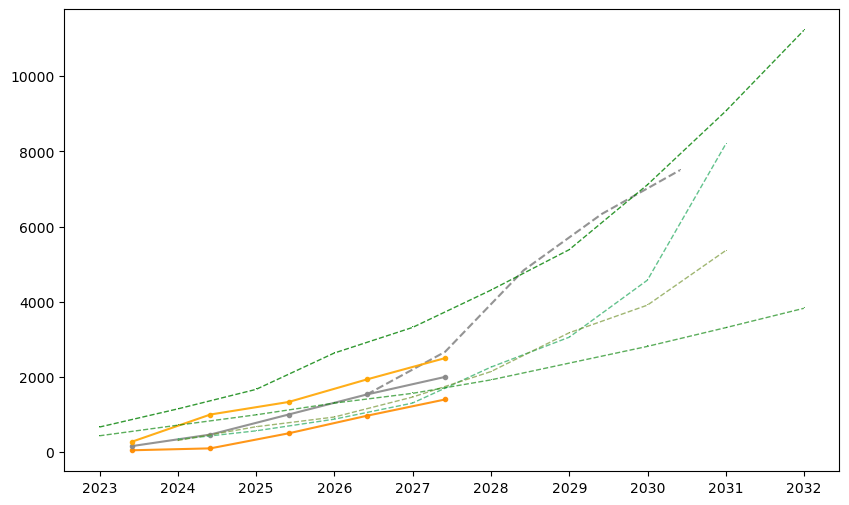

In [13]:
import matplotlib.cm as cm
import numpy as np

# Extend the four year forecast to the end of the data
extendFourYear = True
# Show other forecasts (in addition to ARK)
showOther = True

if not showOther:
    dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

dfTargets = dfTargets.sort_values(['Source', 'ForecastDate', 'TargetDate'])

plt.figure(figsize=(10, 6))

grouped = dfTargets.groupby(['Source'])
for name, group in grouped:
    if name[0] == 'ARKInvest':
        line_color = colors['ark']
        line_alpha = 0.9
        line_width = 1.5
    else:
        rng_color = colors['other'].pop(0)
        colors['other'].append(rng_color)
        line_color = {
            'bear': rng_color,
            'base': rng_color,
            'bull': rng_color,
        }
        line_alpha = 0.8
        line_width = 1.0
        print(name[0]+ ' uses ' + rng_color)
            
    # Plot rolling ongoing forecast eg 4 year forecast updated each year
    rolling_forecast = group.drop_duplicates('ForecastDate')

    # Plot extended forecasts that have the same 'ForecastDate'
    extended_forecast = group.groupby(['ForecastDate'])


    for extended_name, subgroup in extended_forecast:
        if subgroup['Base'].notna().sum() > 1:
            if len(rolling_forecast) > 1:
                label_text = None # Hide label for extended forecasts if rolling forecast is also shown
            else:
                label_text = name[0]
            plt.plot(subgroup.index, subgroup['Base'], linestyle='dashed', marker=',', label=label_text, color=line_color['base'], alpha=line_alpha, linewidth=line_width)
        if subgroup['Bear'].notna().sum() > 1:
            subgroup_bear = subgroup.dropna(subset=['Bear'])
            if len(rolling_forecast) > 1:
                label_text = None # Hide label for extended forecasts if rolling forecast is also shown
            else:
                label_text = name[0]+' Bear'
            line_alpha = line_alpha * 0.8
            plt.plot(subgroup_bear.index, subgroup_bear['Bear'], linestyle='dashed', marker=',', label=label_text, color=line_color['bear'], alpha=line_alpha, linewidth=line_width)



    if len(rolling_forecast) > 1:
        if group['Bear'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
        if group['Base'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
        if group['Bull'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

plt.plot(df.index, df['Price'], color=colors['tsla'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('$ Price')
plt.suptitle('Rolling Multi Year Price Targets')
plt.title('TSLA Target Forecasts')
plt.yticks(list(range(0, 100000, 1000)))
plt.grid(True)

if extendFourYear:
    right_limit = pd.to_datetime('2032-01-01')
    top_limit = 11000
else:
    right_limit = pd.to_datetime('2028-01-01')
    top_limit = 5000
plt.ylim(bottom=0, top=top_limit) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=right_limit)

#plt.yscale('linear')
legend = plt.legend(loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()

### Disclaimer

Not financial advice: All content of this repository is for educational purposes only. No warranty or guarantee or forward looking statements of fit for purpose; do your own research, etc.